# Timer Series Forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Data Set
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

## Load the data

In [3]:
data_path = "data/AEP_hourly.csv"

In [4]:
df = pd.read_csv(data_path, index_col=0)

In [5]:
# check how the data looks like
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [6]:
# check data format
df.dtypes

AEP_MW    float64
dtype: object

In [7]:
df.isna().sum()

AEP_MW    0
dtype: int64

In [8]:
df.index = df.index.astype("datetime64[ns]")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
AEP_MW    121273 non-null float64
dtypes: float64(1)
memory usage: 1.9 MB


## Exploration and Visualization

Possible components of a timer series:
* trend
* seasonality
* cyclic
* randomness


### Visiualize whole time series

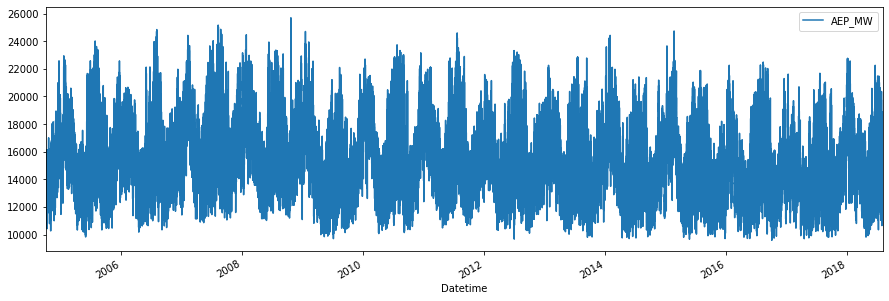

In [10]:
# whole time series
df.plot(figsize=(15,5))

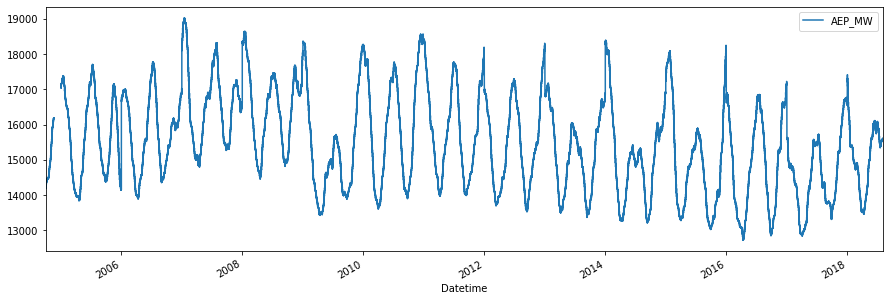

In [11]:
# check for trend with sliding window
df.rolling(window=1000).mean().plot(figsize=(15,5))

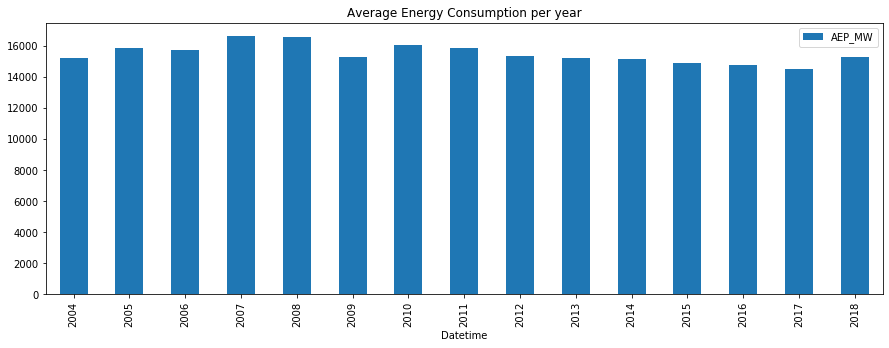

In [12]:
df.groupby(by=[df.index.year]).mean().plot.bar(title="Average Energy Consumption per year", figsize=(15,5))

### Plot annual period

In [13]:
def plot_year(year):   
    # start region - a year
    d_low = pd.Timestamp(f"{year}-01-01")
    d_up = pd.Timestamp(f"{year+1}-01-01")
    df_sub = df[ (df.index > d_low) &
                     ((df.index < d_up))
                ]
    df_sub.plot( y="AEP_MW", title=f"{year} American Electric Power (AEP) Consumption",
                figsize=(15,5)
               )

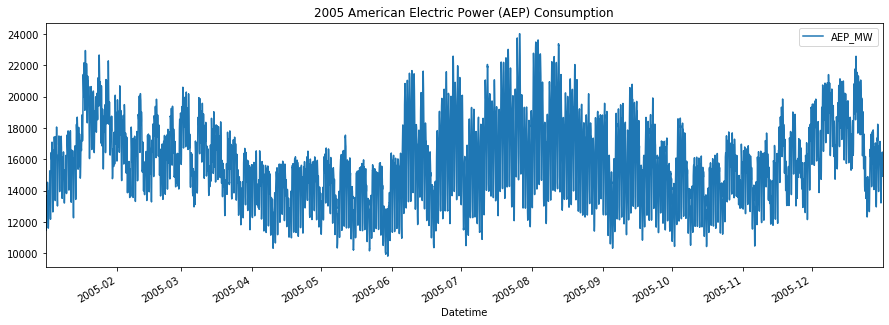

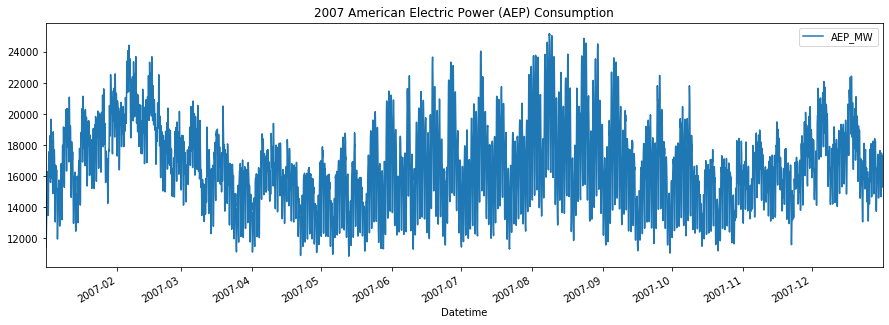

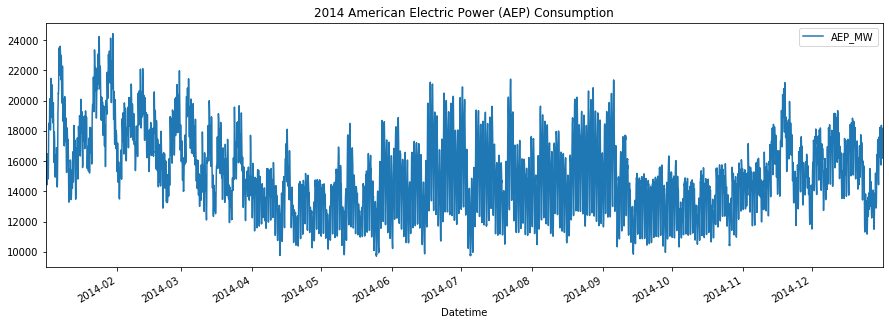

In [14]:
# plot different years
plot_year(2005)
plot_year(2007)
plot_year(2014)

### Plot Daily Period

In [15]:
def plot_day(date_string):   
    # start region - a year
    d_low = pd.Timestamp(date_string)
    d_up = pd.Timestamp(date_string) + pd.Timedelta(days=2)
    df_sub = df[ (df.index > d_low) &
                     ((df.index < d_up))
                ]
    df_sub.plot(y="AEP_MW", title=f"{date_string} AEP Consumption",
                figsize=(15,5)
               )

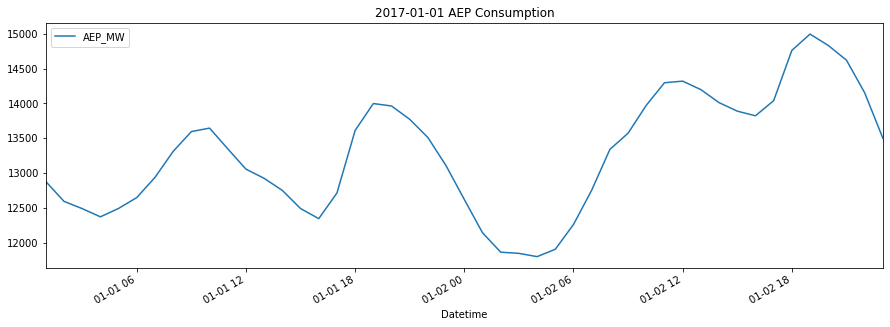

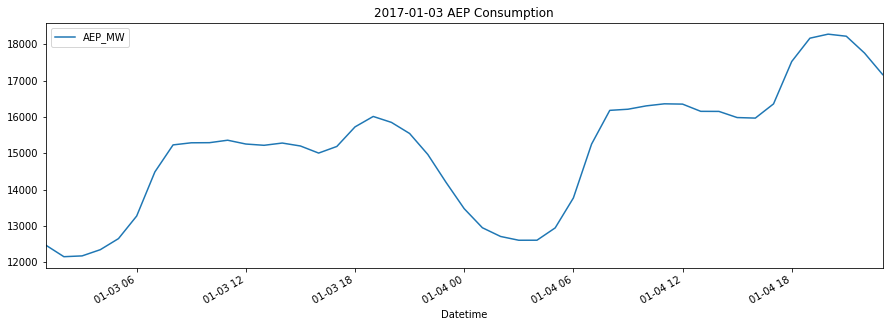

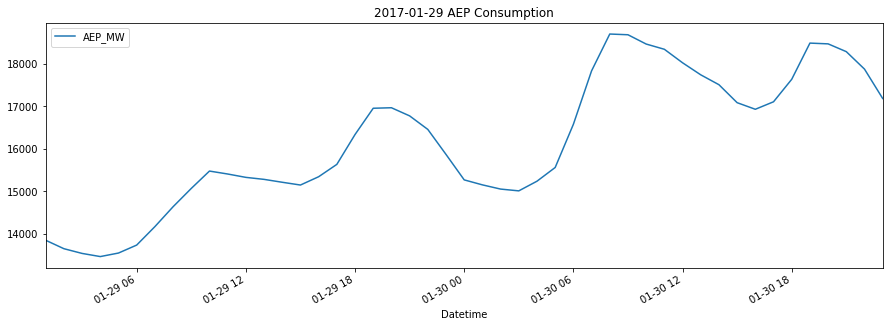

In [16]:
plot_day("2017-01-01")
plot_day("2017-01-03")
plot_day("2017-01-29")

### Plot Monthly Period

In [17]:
def plot_month(date_string):   
    # start region - a year
    d_low = pd.Timestamp(date_string)
    d_up = pd.Timestamp(date_string) + pd.Timedelta(weeks=4)
    df_sub = df[ (df.index > d_low) &
                     ((df.index < d_up))
                ]
    df_sub.plot(y="AEP_MW", title=f"{date_string} AEP Consumption",
                figsize=(15,5)
               )

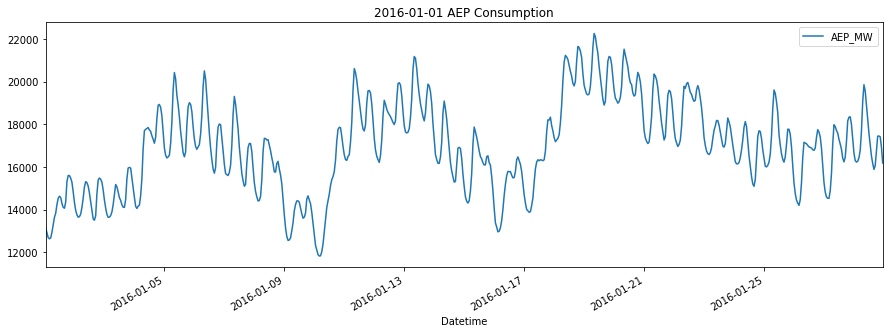

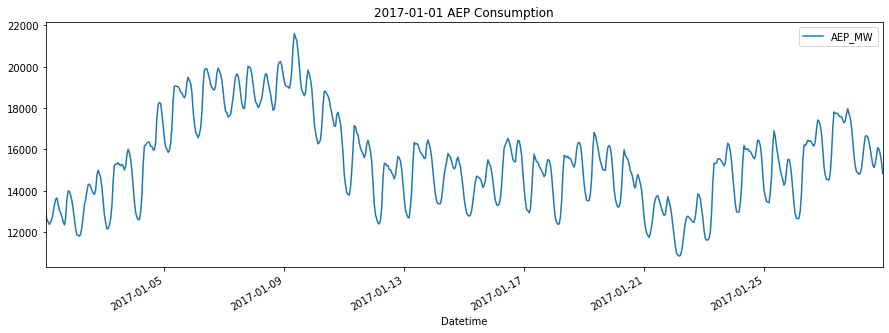

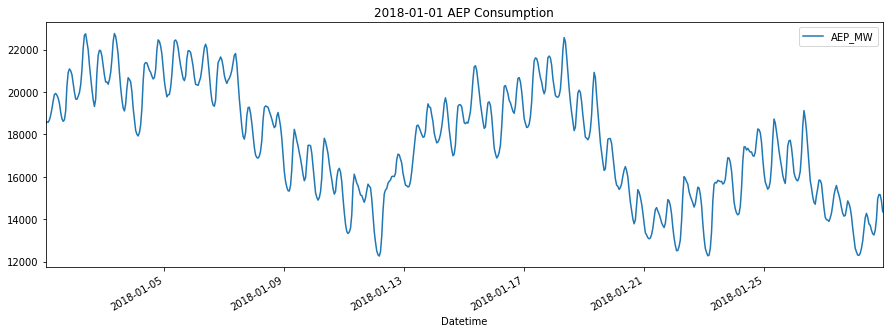

In [18]:
plot_month("2016-01-01")
plot_month("2017-01-01")
plot_month("2018-01-01")

#### Conclusion: This is not a stationary time series
* Seasonality within a year can be seen. Energy consumption peaks around August and December
* Seasonality within a day. Energy consumption peaks at in the morning and evening
* Slight falling trend over the years from 2004 - 2018

#### Check distribution of values

In [19]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x12c81a790>,
 'caps': [<matplotlib.lines.Line2D at 0x12c80eb50>,
 'boxes': [<matplotlib.lines.Line2D at 0x12c80eb10>],
 'medians': [<matplotlib.lines.Line2D at 0x12c81ecd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x12c81add0>],
 'means': []}

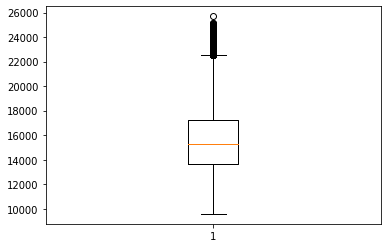

In [20]:
plt.boxplot(df["AEP_MW"])

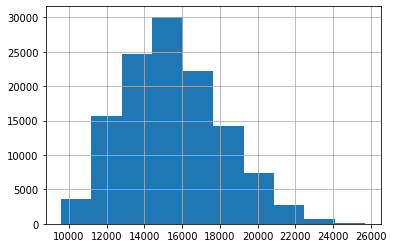

In [21]:
df["AEP_MW"].hist()

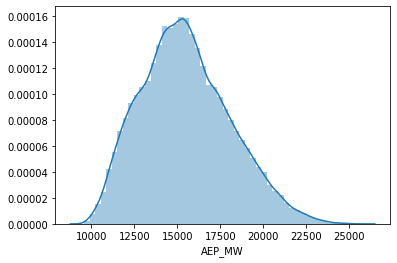

In [22]:
sns.distplot(df["AEP_MW"])

## Data Preparation

In [88]:
# perform a train test split
split_ratio = 0.8

In [89]:
n = df.shape[0]
n

121273

In [90]:
df_sorted = df.sort_index()

In [91]:
split_point = round(n*split_ratio)
split_point

97018

In [92]:
train = df_sorted.iloc[:8000]
train.shape

(8000, 1)

In [93]:
test = df_sorted.iloc[8000:10000]
test.shape

(2000, 1)

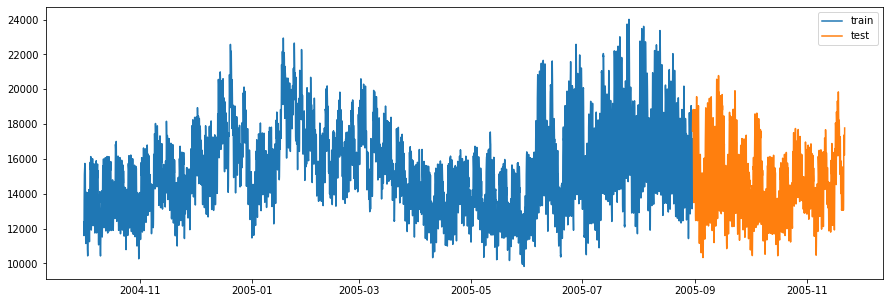

In [29]:
fit = plt.figure(figsize=(15,5))
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.legend()

## Autoregressive integrated moving average (ARIMA) Model

* AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

In [30]:
import statsmodels.api as sm

In [31]:
p = 1 
d = 1
q = 1

In [32]:
mod = sm.tsa.statespace.SARIMAX(train["AEP_MW"],
                                order=(p, d, q),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4176      0.012     33.967      0.000       0.394       0.442
ma.L1          6.2789      0.540     11.628      0.000       5.221       7.337
ar.S.L12      -0.9270      0.004   -221.394      0.000      -0.935      -0.919
sigma2      1083.3921    184.188      5.882      0.000     722.391    1444.393


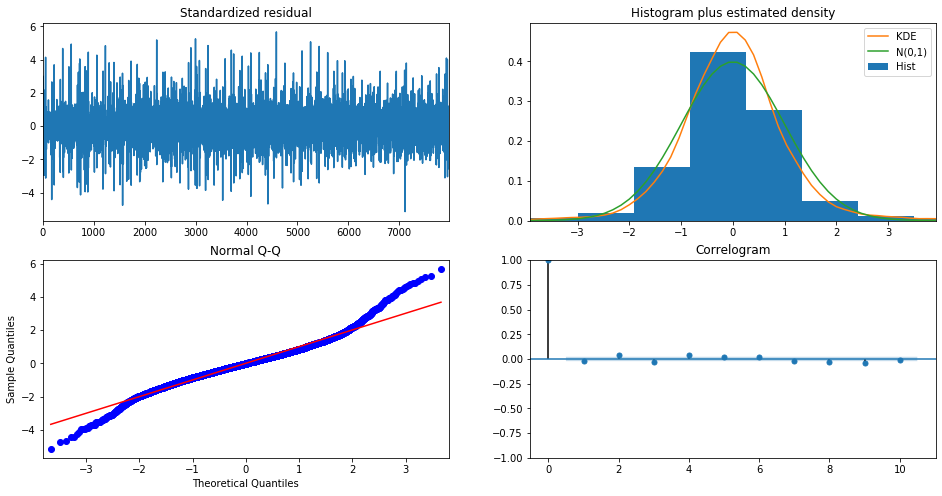

In [33]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Get In-Sample Predictions

In [34]:
last_train_timestamp = train.head(1).index[0]

In [35]:
pred = results.get_prediction(start=last_train_timestamp, dynamic=False)
pred_ci = pred.conf_int()

Text(0.5, 1.0, 'In Sample Predictions')

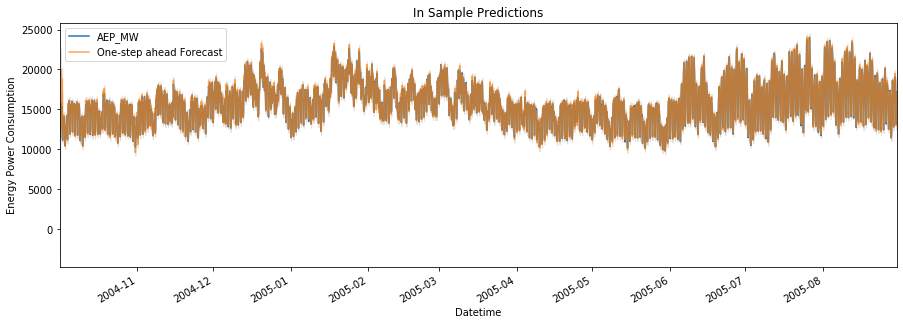

In [36]:
ax = train.plot(label="observed", figsize=(15,5))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.set_ylabel("Energy Power Consumption")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
plt.legend()
plt.title("In Sample Predictions")

In [37]:
fcast = results.get_forecast(steps=2000).summary_frame()
fcast.head()

/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


AEP_MW,mean,mean_se,mean_ci_lower,mean_ci_upper
8000,17564.678909,206.668869,17159.615369,17969.742448
8001,17857.303341,385.903844,17100.945706,18613.660977
8002,18188.272626,538.579533,17132.676138,19243.869114
8003,18559.320972,668.784901,17248.526653,19870.115291
8004,18679.616842,781.947394,17147.028112,20212.205573


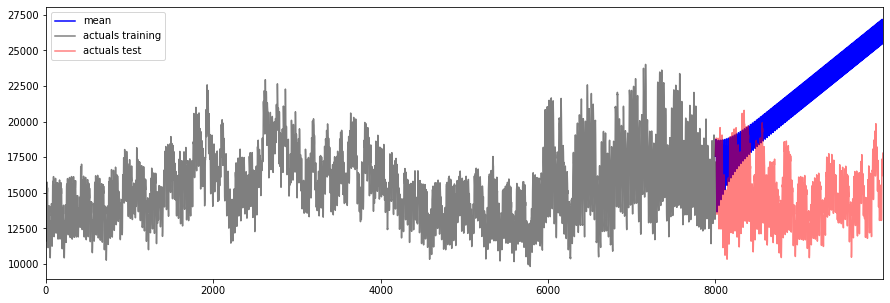

In [38]:
f, ax = plt.subplots(1, figsize=(15,5))

# in-sample forecast
# pred.predicted_mean.reset_index().plot(ax=ax, y=0, label='One-step ahead Forecast', alpha=.7)
# out-of-sample forecast
fcast['mean'].plot(ax=ax, style='b')
# actuals
df_sorted.reset_index().iloc[0:8000].plot(ax=ax, y="AEP_MW", label="actuals training", alpha=0.5, style="k")
df_sorted.reset_index().iloc[8000:10000].plot(ax=ax, y="AEP_MW", label="actuals test", alpha=0.5, style="r")

plt.legend()

In [39]:
y_pred_test = results.forecast(steps=2000).values
y_true_test = test["AEP_MW"].values

/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [40]:
mse = mean_squared_error(y_true_test, y_pred_test)
mse

55790849.92153456

In [41]:
mae = mean_absolute_error(y_true_test, y_pred_test)
mae

6667.755071845576

## Prophet Model from Facebook

At its core, the Prophet procedure is an additive regression model with four main components:

* A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
* A yearly seasonal component modeled using Fourier series.
* A weekly seasonal component using dummy variables.
* A user-provided list of important holidays.

In [204]:
from fbprophet import Prophet

In [205]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [206]:
X, y = create_features(df, "AEP_MW")

In [207]:
features_and_target = pd.concat([X, y], axis=1)
features_and_target = features_and_target.sort_index()

In [208]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,AEP_MW
Datetime,,,,,,,,,
2004-10-01 01:00:00,1,4,4,10,2004,275,1,40,12379.0
2004-10-01 02:00:00,2,4,4,10,2004,275,1,40,11935.0
2004-10-01 03:00:00,3,4,4,10,2004,275,1,40,11692.0
2004-10-01 04:00:00,4,4,4,10,2004,275,1,40,11597.0
2004-10-01 05:00:00,5,4,4,10,2004,275,1,40,11681.0


In [209]:
features_and_target.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 9 columns):
hour          121273 non-null int64
dayofweek     121273 non-null int64
quarter       121273 non-null int64
month         121273 non-null int64
year          121273 non-null int64
dayofyear     121273 non-null int64
dayofmonth    121273 non-null int64
weekofyear    121273 non-null int64
AEP_MW        121273 non-null float64
dtypes: float64(1), int64(8)
memory usage: 9.3 MB


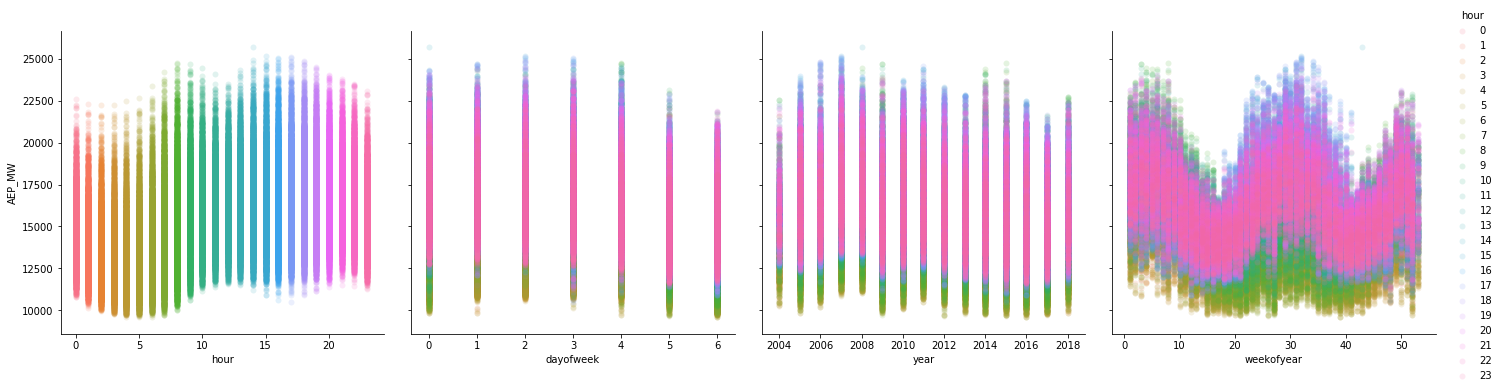

In [210]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='AEP_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
#plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [211]:
# reframe in format that is needed for Prophet
df_new = df_sorted.reset_index().rename(
    columns={"Datetime":"ds", "AEP_MW": "y"}
)

In [212]:
df_new.head()

,ds,y
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0


In [213]:
# create train test split
train_size = 8000
test_size = 2000

train = df_new[:train_size]
test = df_new[train_size:train_size+test_size]

print(f"train shape = {train.shape}")
print(f"test shape = {test.shape}")

train shape = (8000, 2)
test shape = (2000, 2)


In [214]:
train.head()

,ds,y
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0


In [215]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [216]:
y_pred_train = model.predict(train)

In [217]:
y_pred_test = model.predict(test)

In [218]:
y_pred_train.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-10-01 01:00:00,13774.301659,10858.291915,14454.291344,13774.301659,13774.301659,-1108.995967,-1108.995967,-1108.995967,-1521.805481,-1521.805481,-1521.805481,412.809514,412.809514,412.809514,0.0,0.0,0.0,12665.305692
1,2004-10-01 02:00:00,13775.119858,10215.294688,13901.674961,13775.119858,13775.119858,-1754.140348,-1754.140348,-1754.140348,-2167.295448,-2167.295448,-2167.295448,413.155100,413.155100,413.155100,0.0,0.0,0.0,12020.979510
2,2004-10-01 03:00:00,13775.938058,9925.776849,13345.283672,13775.938058,13775.938058,-2133.855974,-2133.855974,-2133.855974,-2546.721086,-2546.721086,-2546.721086,412.865111,412.865111,412.865111,0.0,0.0,0.0,11642.082084
3,2004-10-01 04:00:00,13776.756258,9641.709791,13353.451776,13776.756258,13776.756258,-2197.289932,-2197.289932,-2197.289932,-2609.023205,-2609.023205,-2609.023205,411.733273,411.733273,411.733273,0.0,0.0,0.0,11579.466326
4,2004-10-01 05:00:00,13777.574458,10098.889203,13658.563997,13777.574458,13777.574458,-1914.746078,-1914.746078,-1914.746078,-2324.289046,-2324.289046,-2324.289046,409.542969,409.542969,409.542969,0.0,0.0,0.0,11862.828380


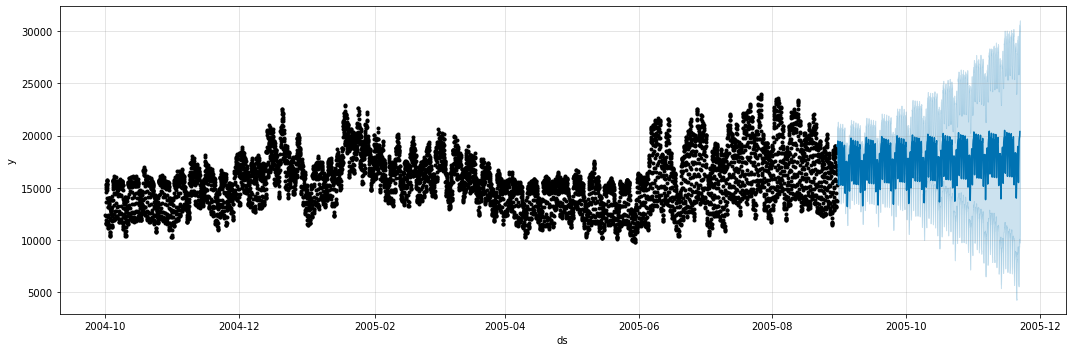

In [219]:
# Plot the forecast of the test set
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(y_pred_test,
                 ax=ax)
plt.show()

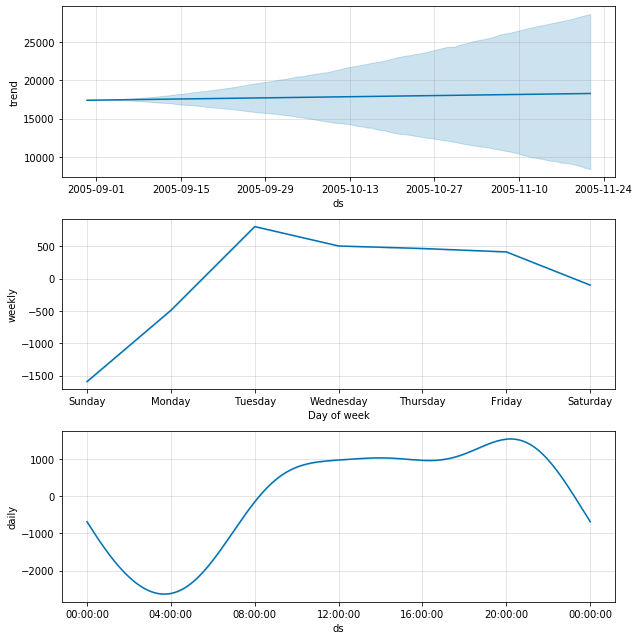

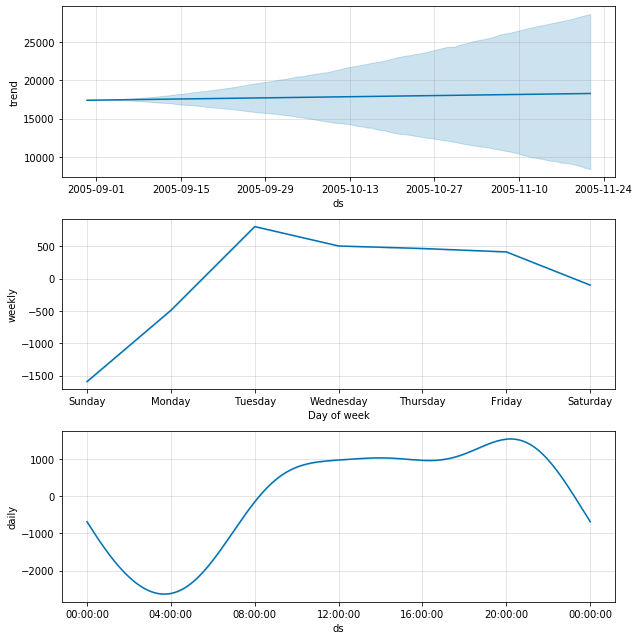

In [220]:
#check components of the forecast
model.plot_components(y_pred_test)

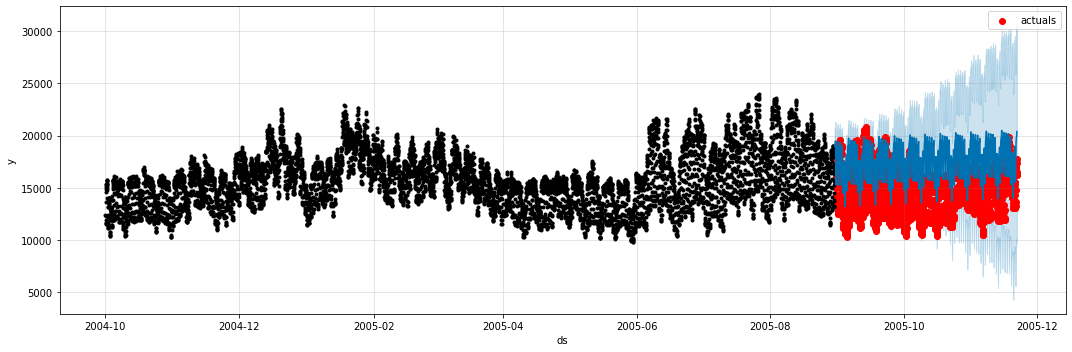

In [221]:
# Compare actuals to forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(y_pred_test,
                 ax=ax)
ax.scatter(test["ds"], test["y"], color="r", label="actuals")
plt.legend()
plt.show()

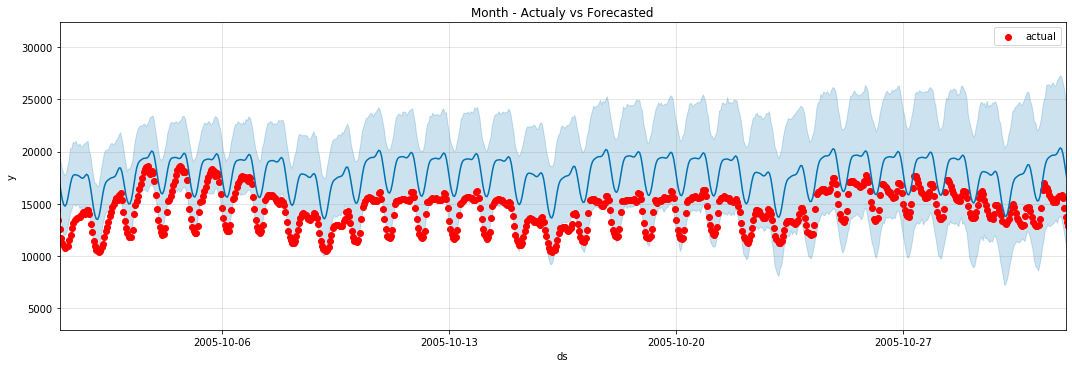

In [240]:
# Compare actuals to forecast within a month
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(y_pred_test, ax=ax)
ax.scatter(test["ds"], test["y"], color="r", label="actual")
ax.set_xbound(
    lower= pd.to_datetime("2005-10-01"),
    upper= pd.to_datetime("2005-11-01")
)
plt.title("Month - Actualy vs Forecasted")
plt.legend()

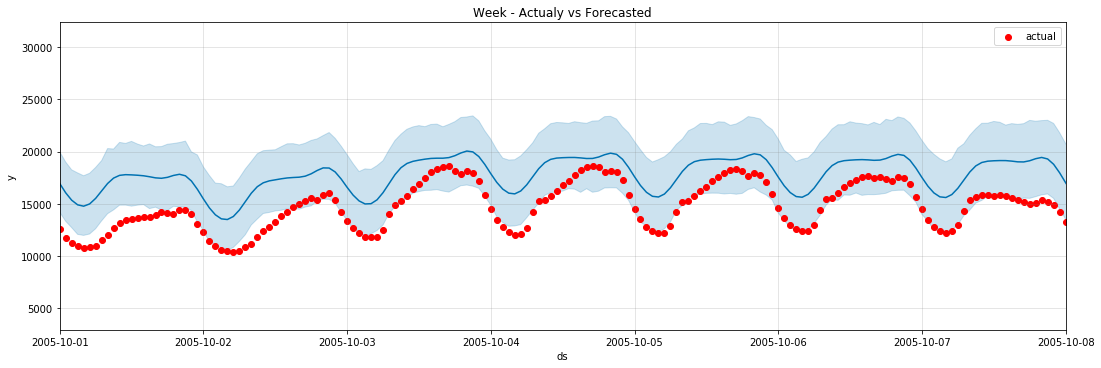

In [241]:
# Compare actuals to forecast within a month
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(y_pred_test, ax=ax)
ax.scatter(test["ds"], test["y"], color="r", label="actual")
ax.set_xbound(
    lower= pd.to_datetime("2005-10-01"),
    upper= pd.to_datetime("2005-10-08")
)
plt.title("Week - Actualy vs Forecasted")
plt.legend()

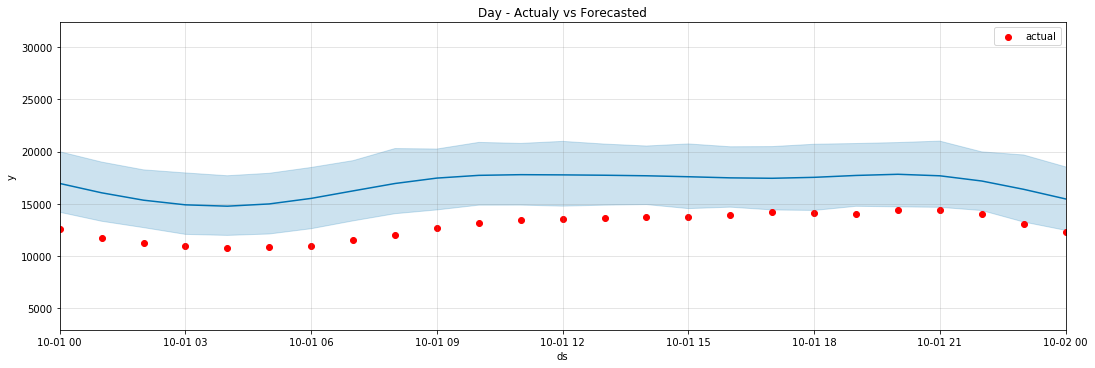

In [242]:
# Compare actuals to forecast within a month
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(y_pred_test, ax=ax)
ax.scatter(test["ds"], test["y"], color="r", label="actual")
ax.set_xbound(
    lower= pd.to_datetime("2005-10-01"),
    upper= pd.to_datetime("2005-10-02")
)
plt.title("Day - Actualy vs Forecasted")
plt.legend()

In [225]:
mse = mean_squared_error(test["y"], y_pred_test["yhat"])
mse

10370450.66977087

In [226]:
mae = mean_absolute_error(test["y"], y_pred_test["yhat"])
mae

2975.240653400277

In [227]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(test["y"], y_pred_test["yhat"])

21.089781550974255

## Long Short Term Memory (LSTM)

In [270]:
import tensorflow as tf
from tensorflow import keras

In [271]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM

In [272]:
def split_timesteps(df, t):
    df_seq = df.copy()
    for rows in range(t, df_seq.shape[0]):
        for i in range(1,t+1):
            df_seq.loc[df_seq.index[rows], f"t-{i}"] = df.loc[df.index[rows-i], "AEP_MW"]
    df_seq = df_seq.dropna()
    return df_seq

In [293]:
df_sorted = df.sort_index()
train = df_sorted.iloc[:8000]
test = df_sorted.iloc[8000:16000]

In [294]:
label = "AEP_MW"
features = [ f"t-{i}" for i in range(1,t+1)]

In [295]:
t = 4
train_seq = split_timesteps(train, t)
test_seq =  split_timesteps(test, t)

In [296]:
X_tr = train_seq[features].values.reshape((-1, 1, 4))
y_tr = train_seq[label]
X_te = test_seq[features].values.reshape((-1, 1, 4))
y_te = test_seq[label]

In [277]:
n_features = len(features)
n_steps = 4

In [278]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_tr.shape[1], X_tr.shape[2])))
lstm_model.add(LSTM(50, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [279]:
lstm_model.fit(X_tr, y_tr, epochs=100, verbose=1)

Epoch 1/100
7996/7996 [==============================] - 1s 141us/step - loss: 77074742.2627
Epoch 2/100
7996/7996 [==============================] - 0s 59us/step - loss: 1618568.3035
Epoch 3/100
7996/7996 [==============================] - 0s 60us/step - loss: 1576482.6857
Epoch 4/100
7996/7996 [==============================] - 0s 62us/step - loss: 1523306.8947
Epoch 5/100
7996/7996 [==============================] - 0s 58us/step - loss: 1456636.4143
Epoch 6/100
7996/7996 [==============================] - 0s 57us/step - loss: 1381398.3776
Epoch 7/100
7996/7996 [==============================] - 0s 59us/step - loss: 1305007.6653
Epoch 8/100
7996/7996 [==============================] - 0s 57us/step - loss: 1208148.6725
Epoch 9/100
7996/7996 [==============================] - 0s 57us/step - loss: 1094781.8492
Epoch 10/100
7996/7996 [==============================] - 0s 58us/step - loss: 974488.2461
Epoch 11/100
7996/7996 [==============================] - 0s 58us/step - loss: 841964.93

In [281]:
y_tr_hat = lstm_model.predict(X_tr)
y_te_hat = lstm_model.predict(X_te)

In [282]:
train_seq["y_hat"] = y_tr_hat
test_seq["y_hat"] = y_te_hat

In [283]:
mse = mean_squared_error(test_seq[label], test_seq["y_hat"])
mse

128604.85332374964

In [284]:
mae = mean_absolute_error(test_seq[label], test_seq["y_hat"])
mae

262.81081450009395

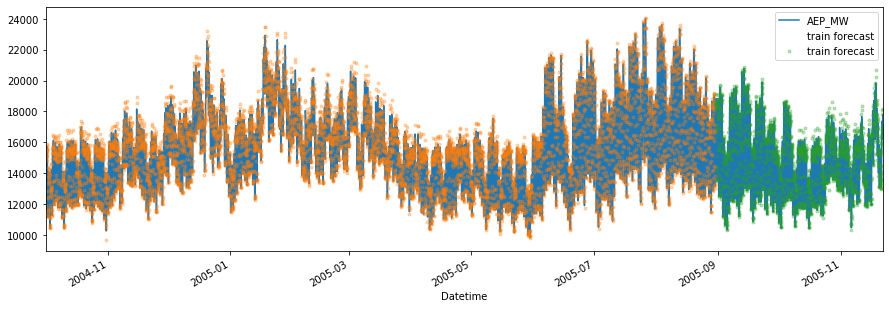

In [285]:
fig, ax = plt.subplots(figsize=(15,5))

pd.concat([train,test]).plot(ax=ax, alpha=1, style="-", label="actual")
train_seq.plot(ax=ax, y="y_hat", style=".", alpha=0.3, label="train forecast")
test_seq.plot(ax=ax, y="y_hat", style=".", alpha=0.3, label="train forecast")

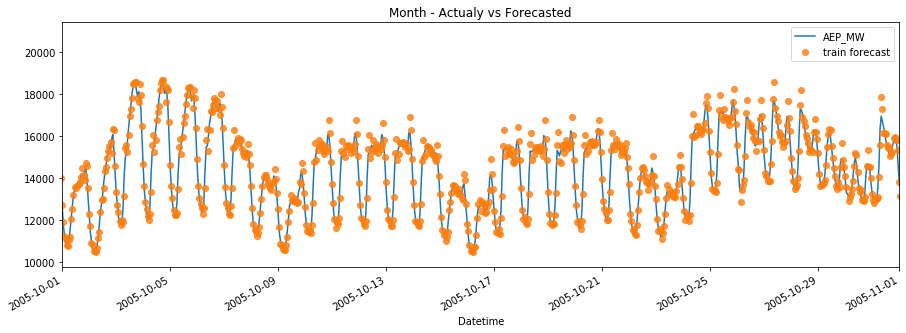

In [290]:
fig, ax = plt.subplots(figsize=(15,5))

test.plot(ax=ax, alpha=1, style="-", label="actual")
test_seq.plot(ax=ax, y="y_hat", style="o", alpha=0.8, label="train forecast")
ax.set_xbound(
    lower= pd.to_datetime("2005-10-01"),
    upper= pd.to_datetime("2005-11-01")
)
plt.title("Month - Actualy vs Forecasted")
plt.legend()

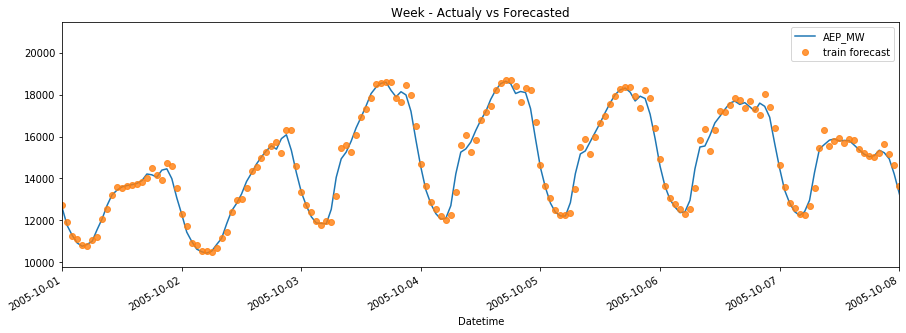

In [291]:
fig, ax = plt.subplots(figsize=(15,5))

test.plot(ax=ax, alpha=1, style="-", label="actual")
test_seq.plot(ax=ax, y="y_hat", style="o", alpha=0.8, label="train forecast")
ax.set_xbound(
    lower= pd.to_datetime("2005-10-01"),
    upper= pd.to_datetime("2005-10-08")
)
plt.title("Week - Actualy vs Forecasted")
plt.legend()

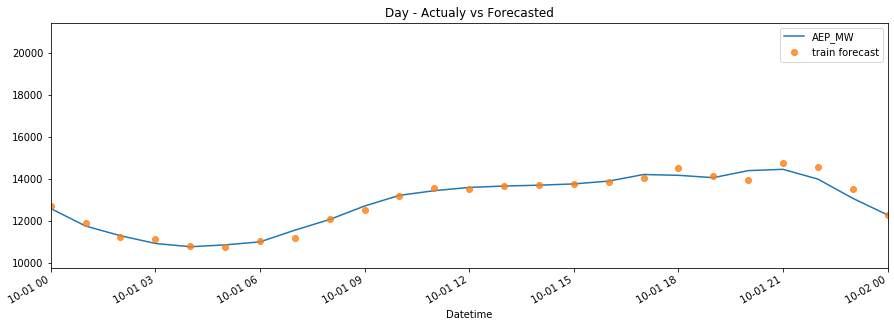

In [292]:
fig, ax = plt.subplots(figsize=(15,5))

test.plot(ax=ax, alpha=1, style="-", label="actual")
test_seq.plot(ax=ax, y="y_hat", style="o", alpha=0.8, label="train forecast")
ax.set_xbound(
    lower= pd.to_datetime("2005-10-01"),
    upper= pd.to_datetime("2005-10-02")
)
plt.title("Day - Actualy vs Forecasted")
plt.legend()